In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  33.226808  1.766888   83.337721                            yes   
1  Female  18.000000  1.600000   55.000000                            yes   
2     NaN  26.000000  1.640741  111.930700                            yes   
3    Male  19.000000  1.690000   64.000000                             no   
4    Male        NaN  1.606474   94.189167                            yes   

  FAVC  FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  TUE  \
0  NaN   2.0       NaN   Sometimes    no  1.964435  no  0.750111  0.0   
1  yes   2.0  3.000000   Sometimes    no  2.000000  no  1.000000  1.0   
2  yes   3.0  3.000000   Sometimes    no  2.617988  no  0.000000  NaN   
3  yes   2.0       NaN  Frequently    no  2.000000  no  0.000000  1.0   
4  yes   2.0  2.812283   Sometimes    no  2.000000  no  1.000000  0.0   

        CALC                 MTRANS           NObeyesdad  
0         no             Automobile  Ov

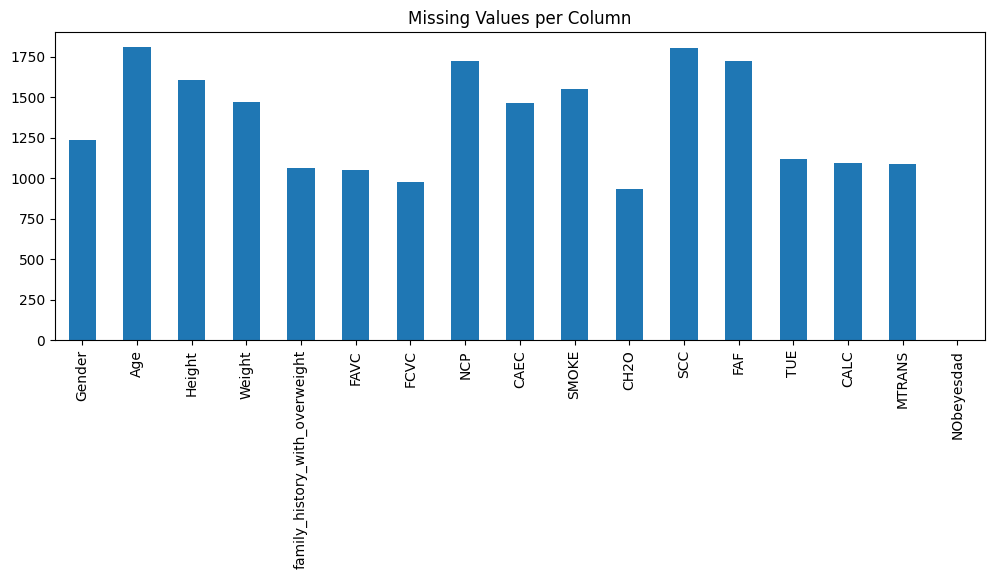

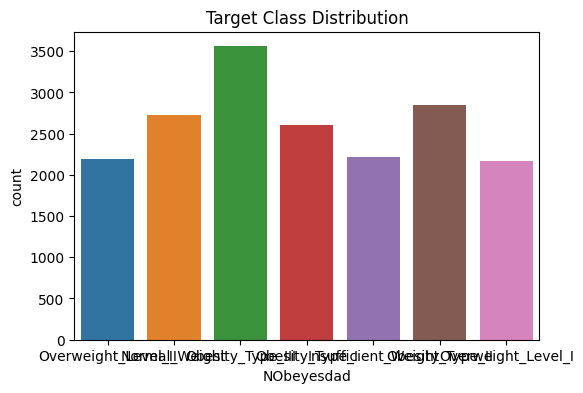

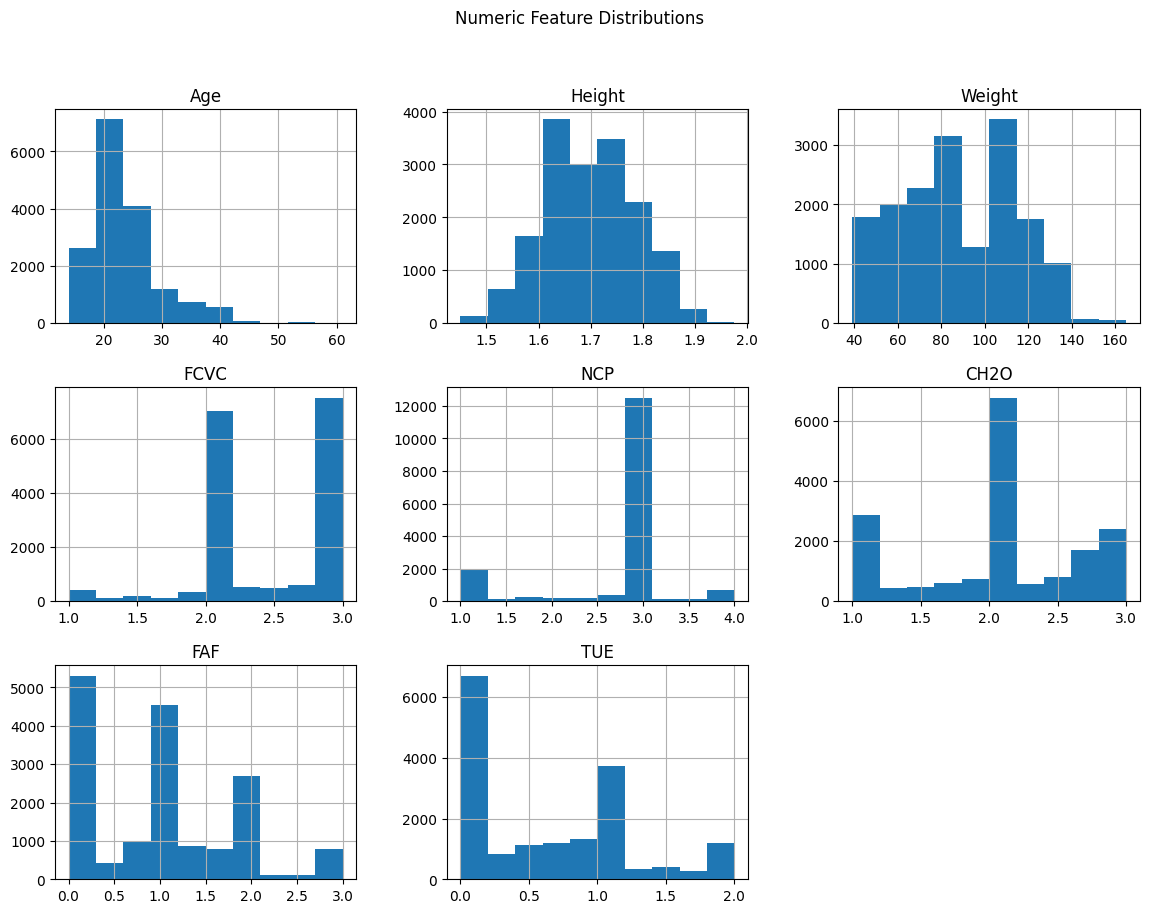

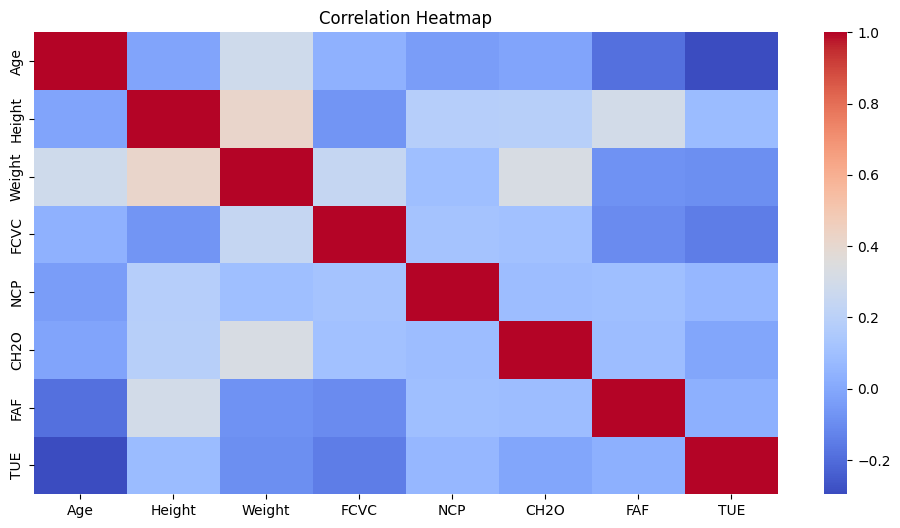

Accuracy : 0.877389404696887
Precision: 0.8682983040712181
Recall   : 0.8645557303419347
F1 Score : 0.8659793576611516
submission_kiet_mse2.csv CREATED SUCCESSFULLY!


,id,NObeyesdad
0,1,Obesity_Type_III
1,2,Normal_Weight
2,3,Obesity_Type_I
3,4,Obesity_Type_II
4,5,Insufficient_Weight


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. LOAD DATA
# ==========================================
train = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/train.csv")
test  = pd.read_csv("/kaggle/input/ai-201-b-mse-2-aiml-a/test.csv")

print(train.head())
print(train.info())
print(train["NObeyesdad"].value_counts())

# ==========================================
# 2. SEPARATE FEATURES & TARGET
# ==========================================
y = train["NObeyesdad"]
X = train.drop("NObeyesdad", axis=1)

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns



plt.figure(figsize=(12,4))
train.isnull().sum().plot(kind='bar')
plt.title("Missing Values per Column")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=train['NObeyesdad'])
plt.title("Target Class Distribution")
plt.show()

X[num_cols].hist(figsize=(14,10))
plt.suptitle("Numeric Feature Distributions")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(X[num_cols].corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


# ==========================================
# 3. HANDLE MISSING VALUES
# ==========================================
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
test[num_cols] = test[num_cols].fillna(X[num_cols].median())

X[cat_cols] = X[cat_cols].fillna(X[cat_cols].mode().iloc[0])
test[cat_cols] = test[cat_cols].fillna(X[cat_cols].mode().iloc[0])

# ==========================================
# 4. ENCODING
# ==========================================
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Label encode output
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Preprocess inputs
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# ==========================================
# 5. RANDOM FOREST MODEL PIPELINE
# ==========================================
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced",
        random_state=42
    ))
])

# ==========================================
# 6. TRAIN–TEST SPLIT
# ==========================================
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# ==========================================
# 7. TRAIN MODEL
# ==========================================
model.fit(X_train, y_train)

# ==========================================
# 8. MODEL EVALUATION
# ==========================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_val)

print("Accuracy :", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred, average='macro'))
print("Recall   :", recall_score(y_val, y_pred, average='macro'))
print("F1 Score :", f1_score(y_val, y_pred, average='macro'))

# ==========================================
# 9. HYPERPARAMETER TUNING (OPTIONAL)
# ==========================================
# You can skip this if you're short on time.
# Uncomment if needed.

# from sklearn.model_selection import GridSearchCV
# params = {
#     "clf__n_estimators": [300, 500, 700],
#     "clf__max_depth": [15, 20, 25]
# }
# grid = GridSearchCV(model, params, cv=3, scoring='f1_macro', n_jobs=-1)
# grid.fit(X_train, y_train)
# model = grid.best_estimator_
# print("Best Params:", grid.best_params_)

# ==========================================
# 10. TRAIN FULL MODEL
# ==========================================
model.fit(X, y_encoded)

# ==========================================
# 11. PREDICT TEST
# ==========================================
test_pred = model.predict(test)
test_labels = le.inverse_transform(test_pred)

# ==========================================
# 12. FINAL SUBMISSION
# ==========================================
submission = pd.DataFrame({
    "id": test["id"],
    "NObeyesdad": test_labels
})

submission.to_csv("submission_kiet_mse3.csv", index=False)

print("submission_kiet_mse2.csv CREATED SUCCESSFULLY!")
submission.head()